<tr>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/HuffPost.svg/320px-HuffPost.svg.png">
</td>
<td>
    <img src="https://upload.wikimedia.org/wikipedia/en/thumb/9/9a/Flag_of_Spain.svg/320px-Flag_of_Spain.svg.png">
</td>


# Analyse des sources de l'édition espagnole du *Huff Post* (2012-2016) en 6 étapes faciles
<hr>

<h3 style="background:teal;color:white;padding:5px">Étape 1 - Initialisation de notre *notebook* et lecture du fichier CSV contenant nos données</h3>

In [1]:
import csv, re, random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats, integrate
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 25
pd.options.mode.chained_assignment = None
%matplotlib inline

On lit notre fichier CSV de base, puis on crée une variable `edition` pour identifier le pays sur lequel on va travailler. La variable `huff` ne contient que les articles de l'édition du pays auquel on s'intéresse ici.

In [2]:
huff = pd.read_csv("scraping-ES-2.csv", low_memory=False)
edition = "Espagne"
huff = huff[huff.pays == edition]
huff.shape

(56348, 12)

Le but de cet exercice étant d'identifier le taux d'originalité du *HuffPost*, on va créer trois variables.

- `HP_oui` contiendra la proportion d'articles qui sont originaux (signés par des employés du *HuffPost* ou des pigistes).
- `HP_non` contiendra la proportion d'articles qui ne sont pas originaux (repris d'agences externes ou d'autres médias).
- `HP_inconnu` contiendra la proportion d'articles dont on ne peut pas établir la provenance.

La somme de ces trois variables équivaudra à 100. On s'en servira pour faire un graphique en pointes de tarte (camembert) à la fin.

In [3]:
HP_oui = 0
HP_non = 0
HP_inconnu = 0

<h3 style="background:teal;color:white;padding:5px">Étape 2 - Filtrer les balises <i>meta</i></h3>

<hr>
Ce ne sont pas tous les articles de cette édition du *Huff Post* qui ont, pour nom dans leurs balises `meta`, l'une ou l'autre des éditions du *Huffington Post*, ou de sa compagnie-mère, AOL

In [4]:
huff.meta.value_counts()

El Huffington Post                                                                                                                                                                                                                   53409
EL PAÍS                                                                                                                                                                                                                              1135 
AS.com                                                                                                                                                                                                                               339  
Cadena SER                                                                                                                                                                                                                           266  
ELMUNDO                                                     

Créons un sous-ensemble avec les articles qui, selon la balise `meta`, semblent issus du *HP*.

In [5]:
metaHP = huff.meta.str.contains("[H,Η,h][U,u][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]", na=False)
huff[metaHP].meta.value_counts()

El Huffington Post     53409
The Huffington Post    38   
EL HUFFINGTON POST     1    
HuffPost UK            1    
Name: meta, dtype: int64

In [6]:
huff[metaHP].shape

(53449, 12)

In [7]:
len(huff) - len(huff[metaHP])

2899

Le calcul ci-haut nous indique qu'on a **2&nbsp;899 articles** qu'on peut d'ores et déjà ranger dans la catégorie des articles qui ne sont *pas* rédigés par l'équipe du *HuffPost*.
<hr>
Examinons cependant de plus près notre sous-ensemble d'articles dont la balise `meta` prétend qu'ils sont issus du *HuffPost* en regardant qui sont les signataires de ces articles. Les signataires se trouvent dans la colonne `byline`. Voyons voir, donc, ce qu'elle contient.

<h3 style="background:teal;color:white;padding:5px">Étape 3 - Identification des articles dont les signataires sont inconnus</h3>

In [8]:
huff[metaHP].byline.value_counts()

EL HUFFINGTON POST ?                                              9432
EL HUFFINGTON POST / AGENCIAS ?                                   7836
Redacción ElHuffPostEl Huffington Post ?                          3022
EL HUFFINGTON POST / EFE ?                                        2832
El HuffPost ?                                                     2414
EL HUFFINGTON POST / EP ?                                         1665
El HuffPost / Agencias ?                                          1578
EFE ?                                                             1314
Redacción ElHuffPostAgencias ?                                    1115
Redacción El HuffPostEl Huffington Post ?                         921 
Redacción ElHuffPostEfe ?                                         817 
Redacción ElHuffPostEuropa Press ?                                783 
                                                                 ...  
Riley Arthur ?                                                    1   
Pilar 

Un certain nombre d'auteurs sont inconnus («&nbsp;?&nbsp;» ou «&nbsp;?&nbsp;?&nbsp;»).<br>
Ceux marqués d'un seul point d'interrogation seront placés dans le sous-ensemble `inconnu1`, ceux qui sont marqués de deux points d'interrogation dans le sous-ensemble `inconnu2`.<br>
Ils représentent cependant à peine **0,15%** du total des articles de cette édition du *Huffington&nbsp;Post*.<br>
Nous allons placer cette proportion dans notre variable `HP_inconnu`.

In [9]:
inconnus1 = huff[metaHP].byline == "? "
inconnus2 = huff[metaHP].byline == "? ?"
HP_inconnu = huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()
HP_inconnu, (HP_inconnu/len(huff))*100

(88, 0.15617235749272379)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 4 - Identification des articles originaux au <i>HuffPost</i></h3>

Examinons maintenant les articles dont la signature contient certaines chaînes de caractères qui correspondent au *Huffington Post* (dans différentes langues, fautes de frappe incluses), ou à sa compagnie-mère, AOL. On va baptiser ce sous-ensemble `signéHP`.

In [10]:
signeHP = huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][signeHP].shape

(48144, 12)

In [11]:
huff[metaHP][signeHP].byline.value_counts(), huff[metaHP][signeHP].byline.value_counts().count()

(EL HUFFINGTON POST ?                                              9432
 EL HUFFINGTON POST / AGENCIAS ?                                   7836
 Redacción ElHuffPostEl Huffington Post ?                          3022
 EL HUFFINGTON POST / EFE ?                                        2832
 El HuffPost ?                                                     2414
 EL HUFFINGTON POST / EP ?                                         1665
 El HuffPost / Agencias ?                                          1578
 Redacción ElHuffPostAgencias ?                                    1115
 Redacción El HuffPostEl Huffington Post ?                         921 
 Redacción ElHuffPostEfe ?                                         817 
 Redacción ElHuffPostEuropa Press ?                                783 
 EL HUFFINGTON POST/AGENCIAS ?                                     673 
                                                                  ...  
 Redacción El HuffPostReuters/Europa Press ?                    

Le *Huffington Post* est nommé, d'une façon ou d'une autre, dans ces quelque **48&nbsp;144 articles** signés par **2&nbsp;179 signataires différents**.<br>
Cela représente plus de **85%** de l'ensemble des articles publiés par l'édition espagnole du *HuffPost* dans la période étudiée.
On peut placer cette proportion dans notre variable `HP_oui`.

In [12]:
HP_oui = huff[metaHP][signeHP].pays.count()
HP_oui, (HP_oui/len(huff))*100

(48144, 85.440477035564712)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 5 - Identification des articles <u>extérieurs</u> au <i>HuffPost</i></h3>

On va donc faire la même opération, mais pour tous les postes dans lesquels **on ne trouve pas** les chaînes de caractères permettant d'identifier le *Huffington&nbsp;Post* dans différentes langues. On va créer un nouveau sous-ensemble qu'on va baptiser `NONsignéHP`.

In [13]:
NONsigneHP = ~huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][NONsigneHP].shape

(5305, 12)

Qui sont ces auteurs qui ne signent pas des articles originaux pour le *HuffPost*?

In [14]:
huff[metaHP][NONsigneHP].byline.value_counts(), huff[metaHP][NONsigneHP].byline.value_counts().count()

(EFE ?                                                             1314
 EUROPA PRESS ?                                                    514 
 Europa Press ?                                                    510 
 José María PatiñoCadena SER ?                                     255 
 Daniel BasteiroPeriodista ?                                       250 
 Agencias ?                                                        214 
 AGENCIAS ?                                                        209 
 MINUBE ?                                                          101 
 ? ?                                                               88  
 COOKPAD ?                                                         62  
 GRAZIA.ES ?                                                       58  
 GRAZIA ?                                                          58  
                                                                   ..  
 OTR/PRESS ?                                                    

Il y a cependant certains intrus dans cette liste. C'est le cas, par exemple, de María Porcel, signataire de **34 articles**, dont la [page d'auteur](http://www.huffingtonpost.es/author/maria-porcel/) nous dit clairement qu'elle fait partie de l'équipe du *HuffPost España*. Même s'ils ne font pas partie de l'équipe, ils sont identifiés comme *periodista*, ce qui signifie journaliste et veut dire que leur article est du contenu original.
Il faut également inclure les articles signés par le *Brasil Post*.
Cela fait donc **735 articles** qui devront être ajoutés à notre variable `HP_oui`.

In [15]:
HP_oui = huff[metaHP][signeHP].pays.count() + 735
HP_oui, (HP_oui/len(huff))*100

(48879, 86.744871157805065)

Pour calculer le pourcentage des articles signés par des auteurs externes, il faut soustraire de notre sous-ensemble `NONsignéHP` les articles contenus dans les deux sous-ensembles `inconnu1` et `inconnu2`, puis additionner les articles qu'on a identifié plus haut dont la balise `meta` ne pouvait pas être associée au *HuffPost*, et enfin retrancher les articles qu'on vient de placer dans la variable `HP_oui`. 

In [16]:
HP_non = huff[metaHP][NONsigneHP].pays.count() - (huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()) + (len(huff) - len(huff[metaHP])) - 735
HP_non, (HP_non/len(huff))*100

(7381, 13.098956484702207)

On a désormais tout ce qu'il nous faut pour faire le camembert évoqué plus haut.

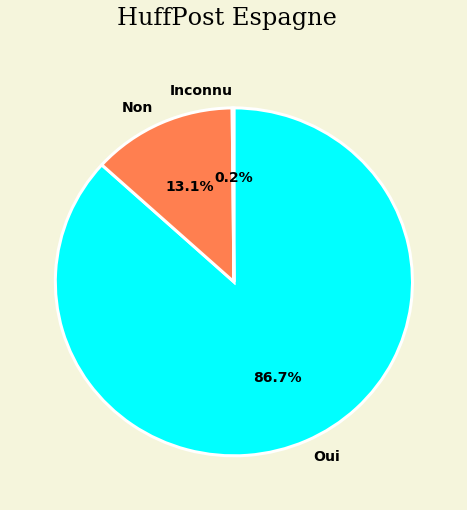

In [17]:
camembert = pd.Series([HP_oui,HP_non,HP_inconnu], index=["Oui","Non","Inconnu"],name="")
titre = plt.figure(facecolor="beige")
titre.suptitle("HuffPost Espagne", fontsize=24, fontweight="light", fontname="Serif")
camembert.plot.pie(colors=["aqua","coral","lightgrey"],
                   wedgeprops={"linewidth":3,"edgecolor":"white"},
                   textprops={"weight":"bold","fontsize":14},
                   counterclock=False,
                   startangle=90,
                   autopct="%1.1f%%",
                   figsize=(8,8)
)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 6 - Exercice boni&nbsp;: les étiquettes (<i>tags</i>)</h3>

Chaque article du *Huffington Post* est généralement accompagné d'une dizaine de marqueurs, ou d'étiquettes (*tags* en anglais). Voici ceux qui sont le plus fréquemment utilisés par cette édition.

In [18]:
etiquettes = huff.set_index('pays').tags.str.split(',', expand=True).stack().rename(columns={0:'tag'}).reset_index(drop=True)
etiquettes.value_counts(dropna=False)

política                            15436
tendencias                          10888
internacional                       9426 
España                              4478 
deportes                            4049 
video                               3732 
pp                                  3726 
economía                            3151 
psoe                                3043 
Mariano Rajoy                       2331 
politica                            2302 
Lo más visto                        2164 
                                    ...  
jovenes emprendedores               1    
in-politics                         1    
youtube niña opera en televisión    1    
mujer racismo koné                  1    
electrodomesticos                   1    
medallas paralímpicas               1    
liga norte                          1    
gorda                               1    
sequía 2012                         1    
acuerdos de paz de oslo             1    
Yves Bolduc education             